 # **<font color='blue'/>Importation des packages et chargement des données**

---



Importation des packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

import datetime as dt
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta

import matplotlib as mpl

from googletrans import Translator, constants

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.datasets import make_blobs

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.ensemble import IsolationForest

import pickle as pk
import os

Importer les modèle PCA et K-Means

In [2]:
pca    = pk.load(open("pca.pkl",'rb'))
kmeans = pk.load(open("kmeans.pkl",'rb'))

chargement des données

In [3]:
df_olist_rfm = pd.read_csv("df_olist_rfm.csv")

Convertir les colonne date en datetime

In [4]:
col_date = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
            'order_delivered_customer_date', 'order_estimated_delivery_date',
            'review_creation_date', 'review_answer_timestamp', 'shipping_limit_date']

df_olist_rfm[col_date] = df_olist_rfm[col_date].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

# **<font color='blue'/>Analyse de stabilité**

---


Fonction pour extraire les clients par période

In [5]:
def customer_delta(df,year,month, delta):
  date = datetime(year, month,1)
  date_delta = date + relativedelta(months=delta)
  date = date - relativedelta(months=11)
  date = date.strftime('%Y-%m')
  date_delta = date_delta.strftime('%Y-%m')

  df_delta = df[(df["order_purchase_timestamp"].dt.strftime('%Y-%m') >= date) & (df["order_purchase_timestamp"].dt.strftime('%Y-%m') <= date_delta)].sort_values('order_purchase_timestamp')

  return df_delta

Etraire une année de données

In [6]:
def customer_one_year(df,year,month):
  date = datetime(year, month,1)
  date_prev = date + relativedelta(months=12)
  date = date.strftime('%Y-%m')
  date_prev = date_prev.strftime('%Y-%m')

  df_month = df[(df["order_purchase_timestamp"].dt.strftime('%Y-%m') >= date) & (df["order_purchase_timestamp"].dt.strftime('%Y-%m') < date_prev)].sort_values('order_purchase_timestamp')
  # print(date)
  # print(date_prev)
  return df_month

La période initiale est d'une année du 2017-01 au 2017-12

In [7]:
# Kmeans de la période initiale
col_pca = ['price', 'review_score' ,'nb_order', 'freight_value', 'Recency', 'Frequency', 'Monetary', 
           'RFMScore','total_payment', 'nb_item', 'payment_sequential', 'nb_payment_installments']

std_scale = StandardScaler()
K=4
data_init = customer_one_year(df_olist_rfm,2017,1).copy()
X_scaled_init = std_scale.fit_transform(data_init[col_pca].values)
X_reduc_init  = pca.fit_transform(X_scaled_init)

kmeans.fit(X_reduc_init)
data_init['Cluster'] = kmeans.predict(X_reduc_init)

L'ARI (Adjusted Rand Index) mesure la similarité entre deux regroupements en considérant toutes les paires d'échantillons et en comptant les paires qui sont attribuées dans les mêmes clusters.

Score ARI pour chaque période : 

In [10]:
ari_score = []
K=4

for p in np.arange(1,9):
    # Créer dataset par période d'un mois
    data_period = customer_delta(df_olist_rfm, 2017,12,p)
    
    # Standardiser les données
    X_scaled_period = std_scale.fit_transform(data_period[col_pca].values)

    # Projeter X sur les composantes principales
    X_reduc_period  = pca.fit_transform(X_scaled_period)
    
    #Prédire les clusters avec le kmeans initial
    data_period['Cluster_init'] = kmeans.predict(X_reduc_period)
        

    # Initialiser KMeans
    kmeans_delta = KMeans(K, random_state=0)
    
    # Entraîner le modèle KMeans et affecter les clusters aux données
    kmeans_delta.fit(X_reduc_period)
    data_period['Cluster'] = kmeans_delta.predict(X_reduc_period)
  
    # Calculer ARI score
    ari_p = adjusted_rand_score(data_period['Cluster'], data_period['Cluster_init'])
    ari_score.append([p,ari_p])
  
ari_score

[[1, 0.9816429454745355],
 [2, 0.9042779097782251],
 [3, 0.8359601499265431],
 [4, 0.7923386828076978],
 [5, 0.6979442733692118],
 [6, 0.342317085290254],
 [7, 0.2877417295859713],
 [8, 0.2689860194859923]]

Graphique des scores ARI

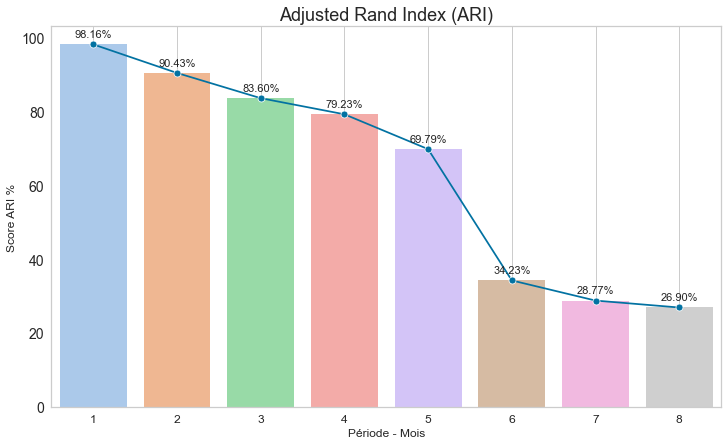

In [11]:
fig, ax = plt.subplots(figsize=(12,7))

df_ari = pd.DataFrame(ari_score, columns=["Periode", "ARI"])

sns.lineplot(x= df_ari['Periode'].index, y = df_ari['ARI']*100, data = df_ari, palette="husl",marker='o')
sns.barplot(x= df_ari['Periode'], y = df_ari['ARI']*100, data = df_ari, palette="pastel")

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    plt.annotate("%.2f" % p.get_height()+'%',
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize = 11,
                #  rotation='vertical',
                )

ax.set_ylabel('Score ARI %', fontsize=12)
# ax.set_ylim(0,100)

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Période - Mois', fontsize=12)
plt.grid()

plt.title('Adjusted Rand Index (ARI)', fontsize=18)

plt.show()

**Remarque**: 

On constate une baisse significative du score ARI au bout du sixième mois.